This notebook is about performance comparison for basic __map__ and __filter__ operators between Rocket.jl, Signals.jl and Reactive.jl

In [1]:
ENV["REACTIVE_CHANNEL_SIZE"] = 1000000

using Rocket
using BenchmarkTools
using Statistics

import Reactive
import Signals

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1273
┌ Info: Precompiling Rocket [df971d30-c9d6-4b37-b8ff-e965b2cb3a40]
└ @ Base loading.jl:1273
┌ Info: Precompiling Reactive [a223df75-4e93-5b7c-acf9-bdd599c0f4de]
└ @ Base loading.jl:1273
┌ Info: Precompiling Signals [6303bc30-01ab-52eb-8b10-60e47555a8d1]
└ @ Base loading.jl:1273


In [2]:
const N = 1000;

In [3]:
# General function for Rocket.jl takes any operator as an argument and sync/async modes
function rocket_jl(operator; mode = ASYNCHRONOUS_SUBJECT_MODE)  
    source = make_subject(Int, mode = mode)
    mapped = source |> operator
    actor  = sync(keep(Int))
    subscribe!(mapped, actor)
    
    for i in 0:N
        next!(source, i)
    end
    complete!(source)
    
    wait(actor)
    
    return actor.actor.values
end;

#### Map operator

In [4]:
function reactive_jl_map()
    x = Reactive.Signal(0)
    mapped = Reactive.map(a -> a ^ 2, x)
    values = Vector{Int}()
    stored = Reactive.map(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    return values
end

function signals_jl_map()
    x = Signals.Signal(0)
    m = Signals.Signal(x -> x ^ 2, x)
    
    values = []
    Signals.when(Signals.Signal(true), m) do value
        push!(values, value)
    end
    
    for i in 1:N
        x(i)
        yield()
    end
    
    return values
end

@CreateMapOperator(Squared, Int, Int, x -> x ^ 2)

squared_operator = SquaredMapOperator();

In [15]:
@assert reactive_jl_map() == rocket_jl(squared_operator, mode = ASYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_map() == rocket_jl(squared_operator, mode = SYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_map() == signals_jl_map()

In [6]:
bmap1 = @benchmark reactive_jl_map();

Signals.async_mode(true)
bmap2 = @benchmark signals_jl_map();

Signals.async_mode(false)
bmap3 = @benchmark signals_jl_map();

bmap4 = @benchmark rocket_jl($squared_operator, mode = ASYNCHRONOUS_SUBJECT_MODE);
bmap5 = @benchmark rocket_jl($squared_operator, mode = SYNCHRONOUS_SUBJECT_MODE);

In [7]:
println("Reactive.jl |         map | ", BenchmarkTools.prettytime(time(bmap1)))
println("Signals.jl  | async + map | ", BenchmarkTools.prettytime(time(bmap2)))
println("Signals.jl  | sync  + map | ", BenchmarkTools.prettytime(time(bmap3)))
println("Rocket.jl   | async + map | ", BenchmarkTools.prettytime(time(bmap4)))
println("Rocket.jl   | sync  + map | ", BenchmarkTools.prettytime(time(bmap5)))

Reactive.jl |         map | 895.324 μs
Signals.jl  | async + map | 30.524 ms
Signals.jl  | sync  + map | 13.751 ms
Rocket.jl   | async + map | 217.365 μs
Rocket.jl   | sync  + map | 97.190 μs


#### Filter operator

In [8]:
function reactive_jl_filter()
    x = Reactive.Signal(0)
    mapped = Reactive.filter(a -> a % 2 == 0, x)
    values = Vector{Int}()
    stored = Reactive.map(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    return values
end

function signals_jl_filter()
    x = Signals.Signal(0)
    m = Signals.filter(x -> x % 2 == 0, 0, x)
    values = []

    Signals.when(Signals.Signal(true), m) do value
        push!(values, value)
    end
    
    for i in 1:N
        x(i)
        yield()
    end
    
    return values
end

@CreateFilterOperator(Even, Int, x -> x % 2 == 0)

even_operator = EvenFilterOperator();

In [9]:
@assert reactive_jl_filter() == rocket_jl(even_operator, mode = ASYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_filter() == rocket_jl(even_operator, mode = SYNCHRONOUS_SUBJECT_MODE)
@assert reactive_jl_filter() == signals_jl_filter()

In [10]:
bfilter1 = @benchmark reactive_jl_filter();

Signals.async_mode(true)
bfilter2 = @benchmark signals_jl_filter();

Signals.async_mode(false)
bfilter3 = @benchmark signals_jl_filter();

bfilter4 = @benchmark rocket_jl($even_operator, mode = ASYNCHRONOUS_SUBJECT_MODE);
bfilter5 = @benchmark rocket_jl($even_operator, mode = SYNCHRONOUS_SUBJECT_MODE);

In [11]:
println("Reactive.jl |         filter | ", BenchmarkTools.prettytime(time(bfilter1)))
println("Signals.jl  | async + filter | ", BenchmarkTools.prettytime(time(bfilter2)))
println("Signals.jl  | sync  + filter | ", BenchmarkTools.prettytime(time(bfilter3)))
println("Rocket.jl   | async + filter | ", BenchmarkTools.prettytime(time(bfilter4)))
println("Rocket.jl   | sync  + filter | ", BenchmarkTools.prettytime(time(bfilter5)))

Reactive.jl |         filter | 894.448 μs
Signals.jl  | async + filter | 28.504 ms
Signals.jl  | sync  + filter | 13.922 ms
Rocket.jl   | async + filter | 214.513 μs
Rocket.jl   | sync  + filter | 103.398 μs


In [12]:
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



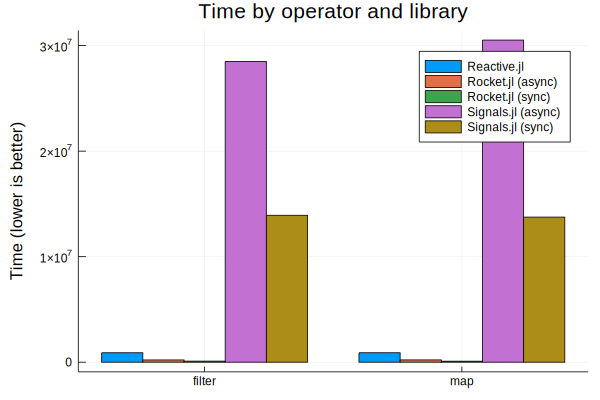

In [18]:
mn = [
    time(bmap1), time(bfilter1),
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
    time(bmap2), time(bfilter2),
    time(bmap3), time(bfilter3)
]
sx = repeat(["Reactive.jl", "Rocket.jl (async)", "Rocket.jl (sync)", "Signals.jl (async)", "Signals.jl (sync)"], inner = 2)
nam = repeat([ "map", "filter" ], outer = 5)

groupedbar(nam, mn, group = sx, ylabel = "Time (lower is better)", title = "Time by operator and library")

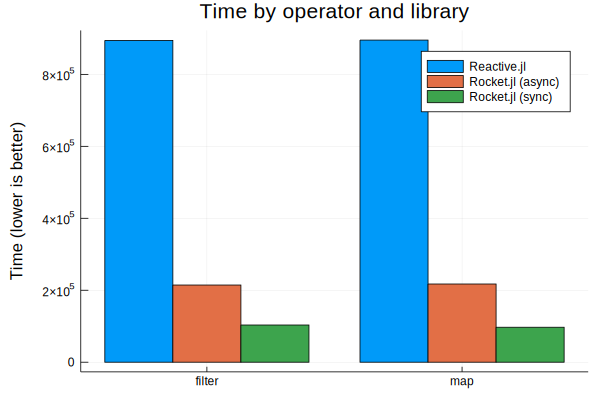

In [33]:
mn = [
    time(bmap1), time(bfilter1),
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
]
sx = repeat(["Reactive.jl", "Rocket.jl (async)", "Rocket.jl (sync)"], inner = 2)
nam = repeat([ "map", "filter" ], outer = 3)

p = groupedbar(nam, mn, group = sx, ylabel = "Time (lower is better)", title = "Time by operator and library")

savefig("pics/reactive-rocket")

display(p)

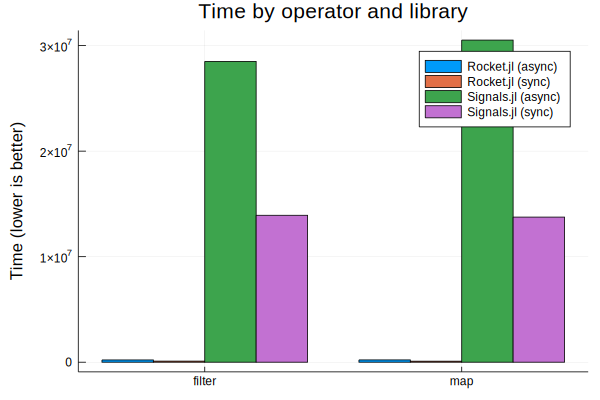

In [34]:
mn = [
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
    time(bmap2), time(bfilter2),
    time(bmap3), time(bfilter3)
]
sx = repeat(["Rocket.jl (async)", "Rocket.jl (sync)", "Signals.jl (async)", "Signals.jl (sync)"], inner = 2)
nam = repeat([ "map", "filter" ], outer = 4)

p = groupedbar(nam, mn, group = sx, ylabel = "Time (lower is better)", title = "Time by operator and library")

savefig("pics/signals-rocket")

display(p)